# Membrane Thickness Analysis Tutorial

- The plots in this tutorial appear as static images for technical reasons, but you can download and display the interactive versions in browser by using the download link below each plot.

## Table of Contents
1. [Introduction](#introduction)
2. [Installation and Setup](#installation-and-setup)
3. [Pipeline Overview](#pipeline-overview)
4. [Input Data and Configuration](#input-data-and-configuration)
5. [Running the Pipeline](#running-the-pipeline)
6. [Command Line Interface](#command-line-interface)
7. [Results Analysis](#results-analysis)
8. [Results Visualization](#results-visualization)
9. [Extract Coordinates of Matched Measurement Points](#extract-coordinates-of-matched-measurement-points)
10. [Convert Thickness Data into Motive Lists](#convert-thickness-data-into-motive-lists)

## Introduction

This tutorial demonstrates how to run the memthick pipeline for measuring membrane thickness from cryo-electron tomography (cryo-ET) membrane segmentations, as well as examples of how to analyze and visualize the output data.

### Pipeline Stages

1. **Input Preparation**:
   - Perform instance membrane segmentations and curate labels. We recommend using [MemBrain-seg](https://github.com/teamtomo/membrain-seg/tree/main) [1] with connected components analysis.
   - For separating or merging labels post-segmentation, we recommend using the 3D lasso tool in the MemBrain v2 napari plugin or the [napari-segselect](https://github.com/bwmr/napari-segselect/tree/main/.napari-hub) plugin [2].
   - Prepare labels (as a config file or dictionary), segmentation, and tomogram files.
   - The input data used in this tutorial is an instance segmentation of a *Chlamydomonas reinhardtii* tomogram [3], containing nuclear envelope (NE), inner and outer mitochondrial membranes (IMM and OMM), generated using [MemBrain-seg](https://github.com/teamtomo/membrain-seg/tree/main) [1]. Input data can be found [here](https://oc.biophys.mpg.de/owncloud/s/aHybCW8qnJbMX7F) along with an example configuration file.
   - The pipeline can also be run on semantic segmentations (i.e., all membrane instances labeled with ones).

2. **Surface Extraction**: Extract surface point coordinates and orientations from segmentations using marching cubes, refine orientations using weighted neighbor averaging, and separate bilayer surfaces using principal component analysis of normal vector orientations.

3. **Thickness Measurement**: Match points between surfaces with geometric constraints (maximum thickness and cone angle search). Measure thickness as Euclidean distance between matched points.

4. **Intensity Profiling**: Extract intensity profiles from the input tomogram along vectors connecting matched points and validate measurements using profile features (user-configurable, for details see [Stage 3: Intensity Profile Analysis](#stage-3-intensity-profile-analysis---building-intuition)).

5. **Quality Filtering**: Remove uncertain measurements based on intensity profile features such as dual minima detection, central maximum presence, and signal-to-noise ratios.

6. **Analysis & Visualization**: Comprehensive statistical analysis and visualization of results with interactive Plotly plots.

#### References:
[1] L. Lamm, *et al.* MemBrain v2: an end-to-end tool for the analysis of membranes in cryo-electron tomography. *bioRxiv*. **2025**. [https://www.biorxiv.org/content/10.1101/2024.01.05.574336v2](https://www.biorxiv.org/content/10.1101/2024.01.05.574336v2)

[2] [napari-segselect: Napari Plugin to clean membrain-seg segmentations](https://github.com/bwmr/napari-segselect/tree/main/.napari-hub)

[3] R. Kelley, *et al.* Towards community-driven visual proteomics with large-scale cryo-electron tomography of Chlamydomonas reinhardtii. *bioRxiv*. **2024** [https://www.biorxiv.org/content/10.1101/2024.12.28.630444v1](https://www.biorxiv.org/content/10.1101/2024.12.28.630444v1)

## Installation and Setup

### Dependencies
```bash
# Core dependencies (should be installed in cryoCAT environment)
pip install pyyaml tqdm plotly pandas
conda install numba -c conda-forge

# Optional: GPU acceleration (recommended for large datasets)
conda install cudatoolkit

In [1]:
%load_ext autoreload
%autoreload 2

from cryocat import memthick # Main pipeline
import memthick_analyze_plot as maple  # Analysis and plotting module

from IPython.display import IFrame

## Pipeline Overview

### Core Parameters Reference

#### Input Files
| Parameter | Description | Default | Notes |
|-----------|-------------|---------|-------|
| `segmentation_path` | Input segmentation MRC file | (required) | Must have correct voxel size metadata |
| `tomo_path` | Tomogram MRC file for intensity analysis | None | Required for intensity profiling |
| `config_path` | YAML file with membrane labels | None | Alternative to `membrane_labels` |
| `membrane_labels` | Dict mapping names to label values | `{"membrane": 1}` | e.g., `{"NE": 1, "ER": 2}` |
| `output_dir` | Output directory | Same as input | Where results are saved |

#### Surface Processing
| Parameter | Description | Default | Recommended | Impact |
|-----------|-------------|---------|-------------|--------|
| `mesh_sampling` | Marching cubes step size | 1 | 1-2 | Higher = faster, less detail |
| `interpolate` | Add interpolated surface points | True | ✓ | Improves surface coverage |
| `interpolation_points` | Points between vertices | 1 | 1-2 | Higher = denser sampling |
| `refine_normals` | Improve normal vectors | True | ✓ | Essential for bilayer separation |
| `radius_hit` | Normal refinement radius (voxels) | 10.0 | 5-15 | 10 should work well |
| `flip_normals` | Orient normals inward | True | ✓ | For thickness measurements |

#### Thickness Measurement
| Parameter | Description | Default | Recommended | Impact |
|-----------|-------------|---------|-------------|--------|
| `max_thickness` | Maximum search distance (nm) | 8.0 | 6-10 | Membrane-dependent |
| `max_angle` | Cone search angle (degrees) | 1.0 | 1-3 | Lower = more precise |
| `direction` | Measurement direction | "1to2" | Try both | Should not affect results |
| `use_gpu` | GPU acceleration | True | ✓ if available | Impacts only the thickness measurement step |

#### Intensity Profiling 
| Parameter | Description | Default | Recommended | Impact |
|-----------|-------------|---------|-------------|--------|
| `extract_intensity_profiles` | Enable intensity analysis | True | ✓ | Required for automated filtering of thickness results |
| `intensity_extension_voxels` | Profile extension distance | 10 | 8-15 | Context around measurement points |
| `intensity_extension_range` | Analysis window | (-10, 10) | Match extension_voxels | Range for feature detection (setting this too wide can be problematic in case of e.g. membrane-bound ribosomes) |
| `intensity_min_snr` | Minimum signal-to-noise ratio | 1.0 | 0.5-2.0 | Peak prominence above baseline noise |
| `intensity_margin_factor` | Position tolerance | 0.0 | 0.1-0.3 | How much further out of the paired points can the minima be detected (0.3 ≈ c.a. 1-1.5 voxels) |
| `intensity_require_both_minima` | Both minima required | True | ✓ | Must find two minima within the measurement range |
| `intensity_central_max_required` | Require central maximum | True | ✓ | Two minima separated by a central maximum |

## Input Data and Configuration

### Example Data Structure
```
project/
├── inputs/
│   ├── segmentation.mrc          # Instance or semantic segmentation
│   ├── tomogram.mrc             # Original tomogram (for intensity)
│   └── config.yml               # Membrane label configuration
└── outputs/                     # Generated results
```

### Configuration File Format
```yaml
# config.yml
NE: 1     
OMM: 2    
IMM: 3     
ER: 4      
```

### Setup Paths

In [2]:
# Input paths
segmentation_path = 'inputs/2738_z200to340_segmented.mrc'
tomo_path = 'inputs/2738_z200to340.mrc'  # For intensity profiling
config_path = 'inputs/config_2738.yml'

# Alternative: Direct label specification
membrane_labels = {
    'NE': 1,
    'OMM': 2, 
    'IMM': 3  
}

# Output directory
output_dir = 'outputs/'

## Running the Pipeline

### 1. Entire Pipeline with Intensity Profiling (Recommended)

In [3]:
# GPU-accelerated full pipeline with intensity profiling
results = memthick.run_full_pipeline(
    segmentation_path=segmentation_path,
    output_dir=output_dir,
    config_path=config_path,  # or membrane_labels=membrane_labels
    
    # Surface processing
    interpolate=True,
    interpolation_points=1,
    refine_normals=True,
    flip_normals=True,
    
    # Thickness measurement  
    max_thickness=8.0,
    max_angle=1.0,
    direction='1to2',
    use_gpu=True,
    
    # Intensity profiling (recommended)
    extract_intensity_profiles=True,
    tomo_path=tomo_path,
    intensity_extension_voxels=8,
    intensity_extension_range=(-8, 8),
    intensity_min_snr=0.1,
    intensity_margin_factor=0.3,  # 30% tolerance for minima positions extending outward from the paired point positions
    intensity_central_max_required=True,
    intensity_require_both_minima=True,
    
    # Optional outputs
    save_vertices_mrc=False,
    save_thickness_mrc=False
)


2025-08-20 15:17:30,220 - Starting full membrane thickness analysis pipeline for inputs/2738_z200to340_segmented.mrc
2025-08-20 15:17:30,223 - Intensity profiling enabled with tomogram: inputs/2738_z200to340.mrc
2025-08-20 15:17:30,224 - Step 1: Processing membrane segmentation
2025-08-20 15:17:30,226 - Reading segmentation from inputs/2738_z200to340_segmented.mrc...
2025-08-20 15:17:30,229 - Voxel size: 0.7840 nm
2025-08-20 15:17:30,230 - Origin: (np.float32(0.0), np.float32(0.0), np.float32(0.0))
2025-08-20 15:17:30,231 - Shape (ZYX): (141, 1024, 1024)
2025-08-20 15:17:30,232 - 
Processing NE (label 1)
2025-08-20 15:17:30,299 - Extracting surface points with step size 1...
2025-08-20 15:17:30,300 - Extracting surface points with step size 1...
2025-08-20 15:17:35,480 - Extracted 371023 surface points
2025-08-20 15:17:36,312 - Extracted 371023 surface points
2025-08-20 15:17:36,313 - Interpolating surface points (before: 371023 vertices)
2025-08-20 15:17:52,088 - Interpolation: 371023

Reading tomogram from inputs/2738_z200to340.mrc...
Tomogram voxel size: 0.7840 nm
Tomogram shape (ZYX): (141, 1024, 1024)
Normalizing tomogram using method: zscore
Extracting intensity profiles with extension of 8 voxels
Including physical coordinates with voxel size: 0.7840 nm
Processing 221676 valid coordinate pairs
Extracting intensity values for 221676 profiles...


2025-08-20 15:22:18,466 - Extracted 221676 intensity profiles
2025-08-20 15:22:18,467 - 
Filtering intensity profiles...
2025-08-20 15:22:18,468 - === Statistics of the extracted intensity profiles ===


Successfully extracted 221676 intensity profiles


2025-08-20 15:22:49,836 - Step 1: Found 164795 candidate profiles
2025-08-20 15:22:49,837 - Median separation: 4.87 ± 0.88 voxels
2025-08-20 15:22:49,838 - Median prominence SNR: 4.1x
2025-08-20 15:22:49,839 - 
=== Apply filtering criteria: (1) two minima (with user-defined SNR compared to baseline) separated by max; (2) the min are positioned between the two matched points from which thickness was measured ===
2025-08-20 15:23:32,288 - Step 2: 200594/221676 profiles passed the filtering criteria (90.5%)
2025-08-20 15:23:32,632 - 
Saving results to: outputs/


=== Summary of intensity profiles post filtering ===
Total profiles analyzed: 221,676
Candidate profiles found after step 1: 164,795
Profiles that passed criteria: 200,594 (90.5%)
Profiles excluded: 21,082 (9.5%)
=== Characteristics of intensity profiles ===
Median separation of minima: 4.87 ± 0.88 voxels
Median SNR of minima: 4.1x (minima are 4.1x more pronounced than the baseline)
=== Applied filtering criteria (user-defined) ===
Required SNR of minima: 0.1x (minima must be 0.1x more pronounced than the baseline)
Position filtering: Exact (no margin)
Central max required: True
Extension range from midpoint: (-8, 8) voxels
=== Reasons for intensity profile exclusion ===
  minima_outside_extended_region: 18,106 (8.2%)
  insufficient_snr_min1: 2,923 (1.3%)
  no_central_maximum: 39 (0.0%)
  insufficient_snr_min0: 14 (0.0%)
=== Quality metrics of included profiles ===
Mean separation of minima: 4.91 ± 0.90 voxels
  Median separation of minima: 4.87, Range: 1.85-13.44
Mean SNR of minima: 4

2025-08-20 15:24:02,925 - Intensity profiling for NE completed successfully
2025-08-20 15:24:02,928 -   Profiles extracted: 221676
2025-08-20 15:24:02,929 -   Profiles after filtering: 200594
2025-08-20 15:24:02,931 -   Filter pass rate: 90.5%
2025-08-20 15:24:02,931 - 
Processing thickness for OMM
2025-08-20 15:24:02,933 - Reading segmentation from inputs/2738_z200to340_segmented.mrc...
2025-08-20 15:24:02,934 - Voxel size: 0.7840 nm
2025-08-20 15:24:02,935 - Origin: (np.float32(0.0), np.float32(0.0), np.float32(0.0))
2025-08-20 15:24:02,936 - Shape (ZYX): (141, 1024, 1024)
2025-08-20 15:24:02,937 - Loading data from outputs/2738_z200to340_segmented_OMM_vertices_normals.csv...
2025-08-20 15:24:03,080 - CUDA GPU is available and will be used
2025-08-20 15:24:03,081 - Starting thickness measurement (1to2)...
2025-08-20 15:24:03,082 - Measuring thickness from surface 1 to surface 2...
2025-08-20 15:24:03,083 - Starting GPU thickness measurement with 174727 points...
2025-08-20 15:24:03,0

Reading tomogram from inputs/2738_z200to340.mrc...
Tomogram voxel size: 0.7840 nm
Tomogram shape (ZYX): (141, 1024, 1024)
Normalizing tomogram using method: zscore
Extracting intensity profiles with extension of 8 voxels
Including physical coordinates with voxel size: 0.7840 nm
Processing 70793 valid coordinate pairs
Extracting intensity values for 70793 profiles...


2025-08-20 15:24:10,055 - Extracted 70793 intensity profiles
2025-08-20 15:24:10,056 - 
Filtering intensity profiles...
2025-08-20 15:24:10,057 - === Statistics of the extracted intensity profiles ===


Successfully extracted 70793 intensity profiles


2025-08-20 15:24:19,103 - Step 1: Found 25887 candidate profiles
2025-08-20 15:24:19,104 - Median separation: 5.09 ± 1.45 voxels
2025-08-20 15:24:19,105 - Median prominence SNR: 3.8x
2025-08-20 15:24:19,106 - 
=== Apply filtering criteria: (1) two minima (with user-defined SNR compared to baseline) separated by max; (2) the min are positioned between the two matched points from which thickness was measured ===
2025-08-20 15:24:32,248 - Step 2: 36971/70793 profiles passed the filtering criteria (52.2%)
2025-08-20 15:24:32,343 - 
Saving results to: outputs/


=== Summary of intensity profiles post filtering ===
Total profiles analyzed: 70,793
Candidate profiles found after step 1: 25,887
Profiles that passed criteria: 36,971 (52.2%)
Profiles excluded: 33,822 (47.8%)
=== Characteristics of intensity profiles ===
Median separation of minima: 5.09 ± 1.45 voxels
Median SNR of minima: 3.8x (minima are 3.8x more pronounced than the baseline)
=== Applied filtering criteria (user-defined) ===
Required SNR of minima: 0.1x (minima must be 0.1x more pronounced than the baseline)
Position filtering: Exact (no margin)
Central max required: True
Extension range from midpoint: (-8, 8) voxels
=== Reasons for intensity profile exclusion ===
  minima_outside_extended_region: 27,250 (38.5%)
  insufficient_snr_min1: 6,352 (9.0%)
  no_central_maximum: 168 (0.2%)
  insufficient_snr_min0: 47 (0.1%)
  zero_baseline_noise: 5 (0.0%)
=== Quality metrics of included profiles ===
Mean separation of minima: 4.79 ± 1.26 voxels
  Median separation of minima: 4.67, Range: 

2025-08-20 15:24:38,930 - Intensity profiling for OMM completed successfully
2025-08-20 15:24:38,933 -   Profiles extracted: 70793
2025-08-20 15:24:38,935 -   Profiles after filtering: 36971
2025-08-20 15:24:38,937 -   Filter pass rate: 52.2%
2025-08-20 15:24:38,938 - 
Processing thickness for IMM
2025-08-20 15:24:38,939 - Reading segmentation from inputs/2738_z200to340_segmented.mrc...
2025-08-20 15:24:38,941 - Voxel size: 0.7840 nm
2025-08-20 15:24:38,942 - Origin: (np.float32(0.0), np.float32(0.0), np.float32(0.0))
2025-08-20 15:24:38,942 - Shape (ZYX): (141, 1024, 1024)
2025-08-20 15:24:38,943 - Loading data from outputs/2738_z200to340_segmented_IMM_vertices_normals.csv...


Saved cleaned intensity profiles with features: outputs/2738_z200to340_segmented_OMM_int_profiles_cleaned.pkl
Saved statistics: outputs/2738_z200to340_segmented_OMM_filtering_stats.txt


2025-08-20 15:24:39,256 - CUDA GPU is available and will be used
2025-08-20 15:24:39,256 - Starting thickness measurement (1to2)...
2025-08-20 15:24:39,257 - Measuring thickness from surface 1 to surface 2...
2025-08-20 15:24:39,258 - Starting GPU thickness measurement with 314937 points...
2025-08-20 15:24:39,259 - Source points: 139731, Target points: 175206
2025-08-20 15:24:39,260 - Max thickness: 8.0 nm (10.20 voxels)
2025-08-20 15:24:39,260 - Max angle: 1.0 degrees
2025-08-20 15:24:39,269 - Launching CUDA kernel with 1231 blocks and 256 threads per block...
2025-08-20 15:24:39,273 - Retrieving results from GPU...
2025-08-20 15:24:39,601 - Processing matches on CPU to ensure one-to-one matching...
2025-08-20 15:24:42,692 - Found 112416 valid thickness measurements
2025-08-20 15:24:42,695 - Mean thickness: 4.84 nm
2025-08-20 15:24:42,697 - Min: 0.78 nm, Max: 8.00 nm
2025-08-20 15:24:42,698 - Processing completed in 3.44 seconds
2025-08-20 15:24:42,710 - Statistics saved to outputs/2

Reading tomogram from inputs/2738_z200to340.mrc...
Tomogram voxel size: 0.7840 nm
Tomogram shape (ZYX): (141, 1024, 1024)
Normalizing tomogram using method: zscore
Extracting intensity profiles with extension of 8 voxels
Including physical coordinates with voxel size: 0.7840 nm
Processing 112416 valid coordinate pairs
Extracting intensity values for 112416 profiles...


2025-08-20 15:24:50,298 - Extracted 112416 intensity profiles
2025-08-20 15:24:50,299 - 
Filtering intensity profiles...
2025-08-20 15:24:50,299 - === Statistics of the extracted intensity profiles ===


Successfully extracted 112416 intensity profiles


2025-08-20 15:25:05,344 - Step 1: Found 48030 candidate profiles
2025-08-20 15:25:05,345 - Median separation: 5.09 ± 1.46 voxels
2025-08-20 15:25:05,345 - Median prominence SNR: 3.7x
2025-08-20 15:25:05,346 - 
=== Apply filtering criteria: (1) two minima (with user-defined SNR compared to baseline) separated by max; (2) the min are positioned between the two matched points from which thickness was measured ===
2025-08-20 15:25:25,941 - Step 2: 68312/112416 profiles passed the filtering criteria (60.8%)
2025-08-20 15:25:26,124 - 
Saving results to: outputs/


=== Summary of intensity profiles post filtering ===
Total profiles analyzed: 112,416
Candidate profiles found after step 1: 48,030
Profiles that passed criteria: 68,312 (60.8%)
Profiles excluded: 44,104 (39.2%)
=== Characteristics of intensity profiles ===
Median separation of minima: 5.09 ± 1.46 voxels
Median SNR of minima: 3.7x (minima are 3.7x more pronounced than the baseline)
=== Applied filtering criteria (user-defined) ===
Required SNR of minima: 0.1x (minima must be 0.1x more pronounced than the baseline)
Position filtering: Exact (no margin)
Central max required: True
Extension range from midpoint: (-8, 8) voxels
=== Reasons for intensity profile exclusion ===
  minima_outside_extended_region: 35,914 (31.9%)
  insufficient_snr_min1: 7,814 (7.0%)
  insufficient_snr_min0: 68 (0.1%)
  no_central_maximum: 304 (0.3%)
  zero_baseline_noise: 4 (0.0%)
=== Quality metrics of included profiles ===
Mean separation of minima: 5.01 ± 1.34 voxels
  Median separation of minima: 4.87, Range:

2025-08-20 15:25:38,375 - Intensity profiling for IMM completed successfully
2025-08-20 15:25:38,377 -   Profiles extracted: 112416
2025-08-20 15:25:38,379 -   Profiles after filtering: 68312
2025-08-20 15:25:38,380 -   Filter pass rate: 60.8%
2025-08-20 15:25:38,381 - 
Full pipeline completed!
2025-08-20 15:25:38,383 - 
=== Intensity Profiling Summary ===
2025-08-20 15:25:38,384 - NE: ✓ Completed - 200594 profiles passed filtering
2025-08-20 15:25:38,385 - OMM: ✓ Completed - 36971 profiles passed filtering
2025-08-20 15:25:38,386 - IMM: ✓ Completed - 68312 profiles passed filtering


Saved cleaned intensity profiles with features: outputs/2738_z200to340_segmented_IMM_int_profiles_cleaned.pkl
Saved statistics: outputs/2738_z200to340_segmented_IMM_filtering_stats.txt


In [ ]:
# Check results
for membrane_name, result in results.items():
    print(f"{membrane_name}:")
    print(f"  Thickness CSV: {result['thickness_csv']}")
    if 'intensity_results' in result:
        int_result = result['intensity_results']
        print(f"  Profiles filtered: {int_result['profiles_filtered']}")
        print(f"  Pass rate: {int_result['pass_rate']:.1%}")
    print()

### 2. CPU-Only Processing

For systems without GPU or when CPU parallelization is preferred (parallelization affects only the thickness measurement step; surface extraction and intensity profiling run on single CPU regardless):

In [ ]:
# CPU-parallelized processing
results_cpu = memthick.run_full_pipeline(
    segmentation_path=segmentation_path,
    output_dir=output_dir,
    membrane_labels=membrane_labels,
    
    # Processing options
    use_gpu=False,
    num_cpu_threads=8,  # Adjust for your system
    batch_size=1000,    # Can be adjusted if memory is an issue but I normally go with 2000

    # Surface processing
    interpolate=True,
    interpolation_points=1,
    refine_normals=True,
    flip_normals=True,
    
    # Thickness measurement  
    max_thickness=8.0,
    max_angle=1.0,
    
    # Intensity profiling (recommended)
    extract_intensity_profiles=True,
    tomo_path=tomo_path,
    intensity_extension_voxels=8,
    intensity_extension_range=(-8, 8),
    intensity_min_snr=0.1,
    intensity_margin_factor=0.3,  # 30% tolerance
    intensity_central_max_required=True,
    intensity_require_both_minima=True,
    
    # Optional outputs
    save_vertices_mrc=False,
    save_thickness_mrc=False
)

### 3. Staged Processing

Run the pipeline in separate stages:

#### Stage 1: Surface Extraction

In [ ]:
surface_results = memthick.process_membrane_segmentation(
    segmentation_path=segmentation_path,
    output_dir=output_dir,
    membrane_labels=membrane_labels,
    interpolate=True,
    interpolation_points=1,
    refine_normals=True,
    flip_normals=True,
    radius_hit=10.0
)

print("Surface extraction completed:")
for membrane, csv_path in surface_results.items():
    print(f"  {membrane}: {csv_path}")

#### Stage 2: Thickness Measurement

In [ ]:
# Measure thickness from pre-processed surfaces
for membrane_name in ['NE', 'OMM', 'IMM']:
    vertices_csv = f'outputs/2738_z200to340_segmented_{membrane_name}_vertices_normals.csv'
    
    thickness_csv, stats_file = memthick.measure_membrane_thickness(
        segmentation_path=segmentation_path,
        input_csv=vertices_csv,
        output_dir=output_dir,
        max_thickness=8.0,
        max_angle=1.0,
        direction='1to2',
        use_gpu=True
    )
    
    print(f"{membrane_name} thickness: {thickness_csv}")

#### Stage 3: Intensity Profile Analysis - Building Intuition

- The input tomogram can be normalized using several methods (controlled by `intensity_normalize_method`):
  - `'zscore'`: Standardize to zero mean and unit variance (recommended)
  - `'minmax'`: Scale to range [0, 1]
  - `'percentile'`: Clip to 1st-99th percentile range
  - `'none'`: Use original intensity values
- Intensity profiles are extracted along lines connecting paired surface points.
- Profiles are extracted with a pre-set extension range from the measurement midpoint. It's important not to extend them too far, otherwise other structures might be detected (e.g., membrane-bound ribosomes), which could confound peak detection. Controlled by `intensity_extension_voxels` (recommended: 8-15) and `intensity_extension_range` (recommended: (-8, 8) to (-15, 15)).
- Profiles can be Gaussian-smoothed if needed to reduce noise (controlled by `intensity_smooth_sigma`, where 0=no smoothing).
- The detected profile features serve as quality criteria for filtering thickness measurements.

##### Detected Profile Features
- **Dual Minima**: Represent lipid headgroups (hydrophilic regions) - enable with `intensity_require_both_minima=True`
- **Central Maximum**: Represents lipid tails (hydrophobic core) - enable with `intensity_central_max_required=True`
- **Baseline**: Calculated from profile edges for SNR estimation - controlled by `intensity_edge_fraction` (recommended: 0.1-0.3)

##### Further Quality Criteria
1. **Signal-to-Noise Ratio**: Minima prominence relative to baseline noise - controlled by `intensity_min_snr` (recommended: 0.1-2.0)
2. **Minima Positioning**: Minima positioned between or near the matched measurement points - controlled by `intensity_margin_factor` (recommended: 0.0-0.3, allowing minima to extend slightly beyond measurement points for curved membranes)


In [ ]:
# Apply intensity-based filtering to existing measurements
for membrane_name in ['NE', 'OMM', 'IMM']:
    thickness_csv = f'outputs/2738_z200to340_segmented_{membrane_name}_thickness.csv'
    
    filter_results = memthick.int_profiles_extract_clean(
        thickness_csv=thickness_csv,
        tomo_path=tomo_path,
        output_dir=output_dir,
        
        # Profile extraction
        intensity_extension_voxels=8,
        intensity_extension_range=(-8, ),
        intensity_normalize_method='zscore',
        
        # Quality filtering
        intensity_min_snr=0.1,
        intensity_central_max_required=True,
        intensity_require_both_minima=True,
        intensity_margin_factor=0.2,
        
        # Smoothing of the profiles
        intensity_smooth_sigma=0.0,  # Personally, would not smooth
        
        # Outputs
        save_cleaned_df=True,
        save_profiles=True,
        save_statistics=True
    )
    
    print(f"{membrane_name} intensity filtering completed")
    print(f"  Profiles passed: {filter_results['statistics']['profiles_passed']}")
    print(f"  Pass rate: {filter_results['statistics']['pass_rate']:.1%}")

## Command Line Interface

Navigate to the `/cryocat/` folder and locate `memthick.py`.

### Run Full Pipeline

```bash
# Full pipeline with intensity profiling (recommended)
python memthick.py \
    segmentation.mrc \
    --mode full \
    --output_dir /path/to/output/
    --membrane_labels NE:1,OMM:2,IMM:3 \
    --interpolate \
    --interpolation_points 1 \
    --extract_intensity \
    --tomo_path tomogram.mrc \
    --max_thickness 8.0 \
    --max_angle 1.0 \
    --intensity_min_snr 0.5 \
    --intensity_margin_factor 0.2 \
    --intensity_central_max_required \
    --intensity_require_both_minima
```
### Run Separate Pipeline Steps

#### Surface Extraction
```bash
python memthick.py \
    segmentation.mrc \
    --mode surface \
    --membrane_labels NE:1,ER:2 \
    --output_dir /path/to/output/
```

#### Thickness Measurement
```bash
# Requires pre-existing vertices_normals.csv from surface extraction
python memthick.py \
    segmentation.mrc \
    --mode thickness \
    --input_csv vertices_normals.csv \
    --max_thickness 8.0 \
    --use_gpu
```

#### Filter Thickness Results
```bash
# Requires pre-existing thickness.csv and tomogram
python memthick.py \
    segmentation.mrc \
    --mode intensity \
    --thickness_csv thickness.csv \
    --tomo_path tomogram.mrc \
    --intensity_min_snr 0.5 \
    --intensity_margin_factor 0.2 \
    --intensity_central_max_required \
    --intensity_require_both_minima
```

### CLI Parameter Reference

#### Required Parameters
- `segmentation_path`: Input segmentation file (positional argument)
- `--mode`: Pipeline mode (`full`, `surface`, `thickness`, `intensity`)

#### Common Options
- `--output_dir`: Output directory (default: same as input file)
- `--membrane_labels`: Comma-separated label mapping (e.g., `NE:1,ER:2`)
- `--config_path`: YAML configuration file (alternative to --membrane_labels)
- `--max_thickness`: Maximum thickness in nm (default: 8.0)
- `--max_angle`: Maximum cone angle in degrees (default: 1.0)
- `--use_gpu` / `--use_cpu`: Processing mode (default: GPU if available)

#### Intensity Profiling Options
- `--extract_intensity`: Enable intensity profiling (flag)
- `--tomo_path`: Tomogram file path (required for intensity modes)
- `--intensity_min_snr`: Minimum signal-to-noise ratio (default: 1.0)
- `--intensity_margin_factor`: Position tolerance, 0.0-0.3 (default: 0.1)
- `--intensity_central_max_required`: Require central maximum (flag)
- `--intensity_require_both_minima`: Require both minima (flag)

## Results Analysis

### 1. Load Data

Outputs were uploaded [here](https://oc.biophys.mpg.de/owncloud/s/GBj4j9BcpjdfWJf)

In [4]:
NE_thickness_csv = 'outputs/2738_z200to340_segmented_NE_thickness_cleaned.csv'
NE_profiles = 'outputs/2738_z200to340_segmented_NE_int_profiles_cleaned.pkl'
NE_profiles_nonfiltered = 'outputs/2738_z200to340_segmented_NE_int_profiles.pkl'

IMM_thickness_csv = 'outputs/2738_z200to340_segmented_IMM_thickness_cleaned.csv'
IMM_profiles = 'outputs/2738_z200to340_segmented_IMM_int_profiles_cleaned.pkl'
IMM_profiles_nonfiltered = 'outputs/2738_z200to340_segmented_IMM_int_profiles.pkl'

OMM_thickness_csv = 'outputs/2738_z200to340_segmented_OMM_thickness_cleaned.csv'
OMM_profiles = 'outputs/2738_z200to340_segmented_OMM_int_profiles_cleaned.pkl'
OMM_profiles_nonfiltered = 'outputs/2738_z200to340_segmented_OMM_int_profiles.pkl'

In [5]:
# Load thickness files and profiles

NE_data = maple.load_membrane_data(thickness_csv=NE_thickness_csv, intensity_profiles_pkl=NE_profiles)
IMM_data = maple.load_membrane_data(thickness_csv=IMM_thickness_csv, intensity_profiles_pkl=IMM_profiles)
OMM_data = maple.load_membrane_data(thickness_csv=OMM_thickness_csv, intensity_profiles_pkl=OMM_profiles)

Loaded 200594 intensity profiles from outputs/2738_z200to340_segmented_NE_int_profiles_cleaned.pkl
Loaded 68312 intensity profiles from outputs/2738_z200to340_segmented_IMM_int_profiles_cleaned.pkl
Loaded 36971 intensity profiles from outputs/2738_z200to340_segmented_OMM_int_profiles_cleaned.pkl


In [6]:
# Check loaded data
print("Data Summary:")
for name, data in [("NE", NE_data), ("IMM", IMM_data), ("OMM", OMM_data)]:
    summary = data.get_summary()
    print(f"{name}: {summary}")

Data Summary:
NE: {'n_thickness_measurements': 200594, 'n_intensity_profiles': 200594, 'thickness_range': (np.float64(1.9204001), np.float64(7.995263)), 'thickness_mean': np.float64(5.715790260377678), 'thickness_std': np.float64(0.6439476034645089), 'coordinate_columns': ['x1_voxel', 'y1_voxel', 'z1_voxel'], 'has_profiles': True}
IMM: {'n_thickness_measurements': 68312, 'n_intensity_profiles': 68312, 'thickness_range': (np.float64(1.7530774), np.float64(7.995263)), 'thickness_mean': np.float64(5.205129820914334), 'thickness_std': np.float64(0.8863175161109151), 'coordinate_columns': ['x1_voxel', 'y1_voxel', 'z1_voxel'], 'has_profiles': True}
OMM: {'n_thickness_measurements': 36971, 'n_intensity_profiles': 36971, 'thickness_range': (np.float64(2.2174869), np.float64(7.995263)), 'thickness_mean': np.float64(4.853210620732467), 'thickness_std': np.float64(0.6645813972741067), 'coordinate_columns': ['x1_voxel', 'y1_voxel', 'z1_voxel'], 'has_profiles': True}


### 2. Extract Thickness Measurements

In [7]:
NE_thickness = maple.analyze_membrane_thickness(
    data=NE_data,
    outlier_removal_method=None       # But can be set to IQR method for filtering the results, percentile as well
)

IMM_thickness = maple.analyze_membrane_thickness(IMM_data)
OMM_thickness = maple.analyze_membrane_thickness(OMM_data)

print(NE_thickness.get_summary())
print(IMM_thickness.get_summary())
print(OMM_thickness.get_summary())


Thickness Analysis Summary:
Number of measurements: 200,594
Mean thickness: 5.72 nm
Standard deviation: 0.64 nm
Median thickness: 5.71 nm
Range: 1.92 - 8.00 nm
IQR: 0.86 nm


Thickness Analysis Summary:
Number of measurements: 68,312
Mean thickness: 5.21 nm
Standard deviation: 0.89 nm
Median thickness: 5.02 nm
Range: 1.75 - 8.00 nm
IQR: 1.26 nm


Thickness Analysis Summary:
Number of measurements: 36,971
Mean thickness: 4.85 nm
Standard deviation: 0.66 nm
Median thickness: 4.83 nm
Range: 2.22 - 8.00 nm
IQR: 0.71 nm



In [8]:
# Access stats
stats = NE_thickness.statistics
print(f"Mean thickness: {stats['mean']:.2f} ± {stats['std']:.2f} nm")
print(f"Median thickness: {stats['median']:.2f} nm")
print(f"Thickness range: {stats['min']:.2f} - {stats['max']:.2f} nm")

Mean thickness: 5.72 ± 0.64 nm
Median thickness: 5.71 nm
Thickness range: 1.92 - 8.00 nm


### 3. Extract Intensity Profile Features

In [9]:
# This is the function that works under the hood of the intensity profile plotting function. Not strictly required as standalone

NE_profiles_analysed = maple.analyze_intensity_profiles(
    data=NE_data,
    extension_range_voxels=(-8, 8),     # When you plot the data, this is the distance you'll see from the midpoint
    bin_profiles_by_thickness=True,     # Bin profiles depending on membrane thickness
    thickness_bin_size_nm=0.20         # Bin size
)

IMM_profiles_analysed = maple.analyze_intensity_profiles(
    data=IMM_data,
    extension_range_voxels=(-8, 8),
    bin_profiles_by_thickness=True,
    thickness_bin_size_nm=0.20
)

OMM_profiles_analysed = maple.analyze_intensity_profiles(
    data=OMM_data,
    extension_range_voxels=(-8, 8),
    bin_profiles_by_thickness=True,
    thickness_bin_size_nm=0.20
)

print(NE_profiles_analysed.get_summary())
print(IMM_profiles_analysed.get_summary())
print(OMM_profiles_analysed.get_summary())



Analyzing 200594 intensity profiles...
Created 25 thickness bins for profiles
Analyzing 68312 intensity profiles...
Created 27 thickness bins for profiles
Analyzing 36971 intensity profiles...
Created 25 thickness bins for profiles

Intensity Profile Analysis Summary:
Number of profiles: 200,594
Extension range: (-8, 8) voxels
Interpolation points: 201
Profile type: filtered
Binned profiles: Yes
Number of thickness bins: 25


Intensity Profile Analysis Summary:
Number of profiles: 68,312
Extension range: (-8, 8) voxels
Interpolation points: 201
Profile type: filtered
Binned profiles: Yes
Number of thickness bins: 27


Intensity Profile Analysis Summary:
Number of profiles: 36,971
Extension range: (-8, 8) voxels
Interpolation points: 201
Profile type: filtered
Binned profiles: Yes
Number of thickness bins: 25



### 4. Perform a leaflet asymmetry analysis

Calculate the ratio of the intensity differences between each minimum and the central maximum (asymmetry score)

#### Asymmetry scores
- **Symmetric membranes**: Scores near 1.0 (0% asymmetry)
- **Asymmetric membranes**: Scores e.g., >1.2 (>20% asymmetry)
- **Check for outliers**: Using the bubble plot or 3D plot

In [10]:
NE_asymmetry = maple.analyze_membrane_asymmetry(
    data=NE_data,
    thickness_bin_size_nm=0.2,         # Bin size for analysis
    min_profiles_per_bin=30,           # Minimum profiles required for the bin to be considered
    use_unity_scoring=True,            # 1.0 = symmetric, >1.0 = asymmetric
    use_median_aggregation=True,
    outlier_removal_method=None,      # But outliers can be removed based on IQR filtering
)

print(NE_asymmetry.get_asymmetry_summary())

# Access results
results_df = NE_asymmetry.bin_results
mean_asymmetry = results_df['asymmetry_score'].mean()
print(f"Mean asymmetry score: {mean_asymmetry:.2f}")

IMM_asymmetry = maple.analyze_membrane_asymmetry(
    data=IMM_data, 
    thickness_bin_size_nm=0.2, 
    min_profiles_per_bin=30,    
    use_unity_scoring=True,     
    use_median_aggregation=True 
)

OMM_asymmetry = maple.analyze_membrane_asymmetry(
    data=OMM_data, 
    thickness_bin_size_nm=0.2,  
    min_profiles_per_bin=30,   
    use_unity_scoring=True,     
    use_median_aggregation=True 
)

Starting asymmetry analysis on 200594 profiles...
Created 31 bins from 1.9 to 8.0 nm
    Processed bin 3.42 nm: 55 profiles, asymmetry = 1.326
    Processed bin 3.62 nm: 44 profiles, asymmetry = 1.073
    Processed bin 3.82 nm: 203 profiles, asymmetry = 1.135
    Processed bin 4.02 nm: 478 profiles, asymmetry = 1.050
    Processed bin 4.22 nm: 2,021 profiles, asymmetry = 1.065
    Processed bin 5.22 nm: 26,371 profiles, asymmetry = 1.069
    Processed bin 6.22 nm: 15,461 profiles, asymmetry = 1.058
    Processed bin 7.22 nm: 1,885 profiles, asymmetry = 1.036
Successfully calculated asymmetry for 24 bins
Rejected 7 bins (insufficient profiles)

=== Asymmetry Analysis Summary ===
Total profiles analyzed: 200,570
Mean asymmetry: 6.6%
Median asymmetry: 5.5%
Highly asymmetric bins (>20%): 1/24 (4.2%)
Intensity-based calculations: 24
Position-based calculations: 0

Asymmetry Analysis Summary:
Total bins created: 24
Valid bins: 24
Rejected bins: 7
Total profiles analyzed: 200,570

Asymmetry S

## Results Visualization

### 1. Thickness distributions

In [ ]:
thickness_plot = maple.plot_thickness_distribution(
    data=[NE_thickness, IMM_thickness, OMM_thickness],
    membrane_names=['NE', 'IMM', 'OMM'],
    histogram_bins=40,
    thickness_range=(1, 10),
    show_statistics=True,
    show_mean_lines=True,
    density_normalization=True,
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    plot_title='Organelle Thickness Distributions'
)

#thickness_plot.show()
thickness_plot.write_html("plots/thickness_distribution.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/thickness_distribution.html", width=800, height=600)

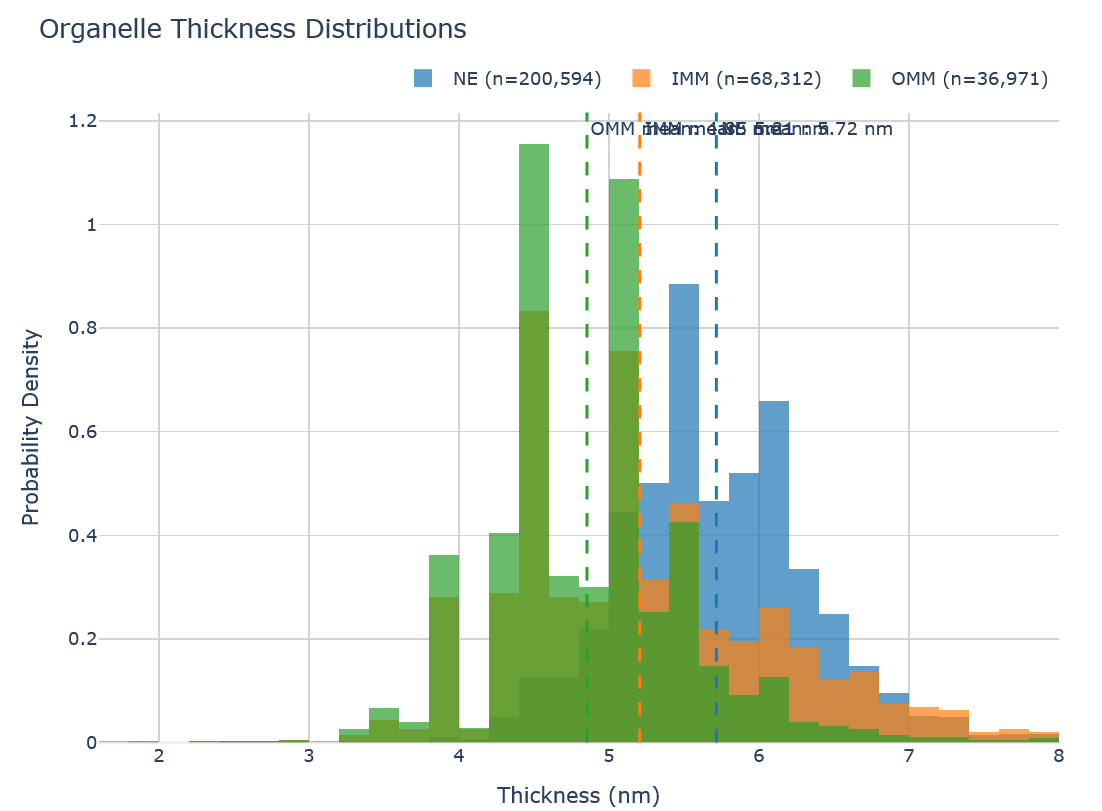

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/thickness_distribution.html)

### 2. Membrane thickness maps

In [ ]:
spatial_plot = maple.plot_thickness_3d(
    data=[NE_thickness, IMM_thickness, OMM_thickness],
    membrane_names=['NE', 'IMM', 'OMM'],
    color_scale='OrRd',
    color_range=(2, 8),                # Thickness color range
    marker_size=2,
    sample_fraction=0.5,               # Downsample for quicker visualization
    plot_title='Membrane thickness maps'
)

#spatial_plot.show()
spatial_plot.write_html("plots/thickness_3d_plot.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/thickness_3d_plot.html", width=800, height=600)

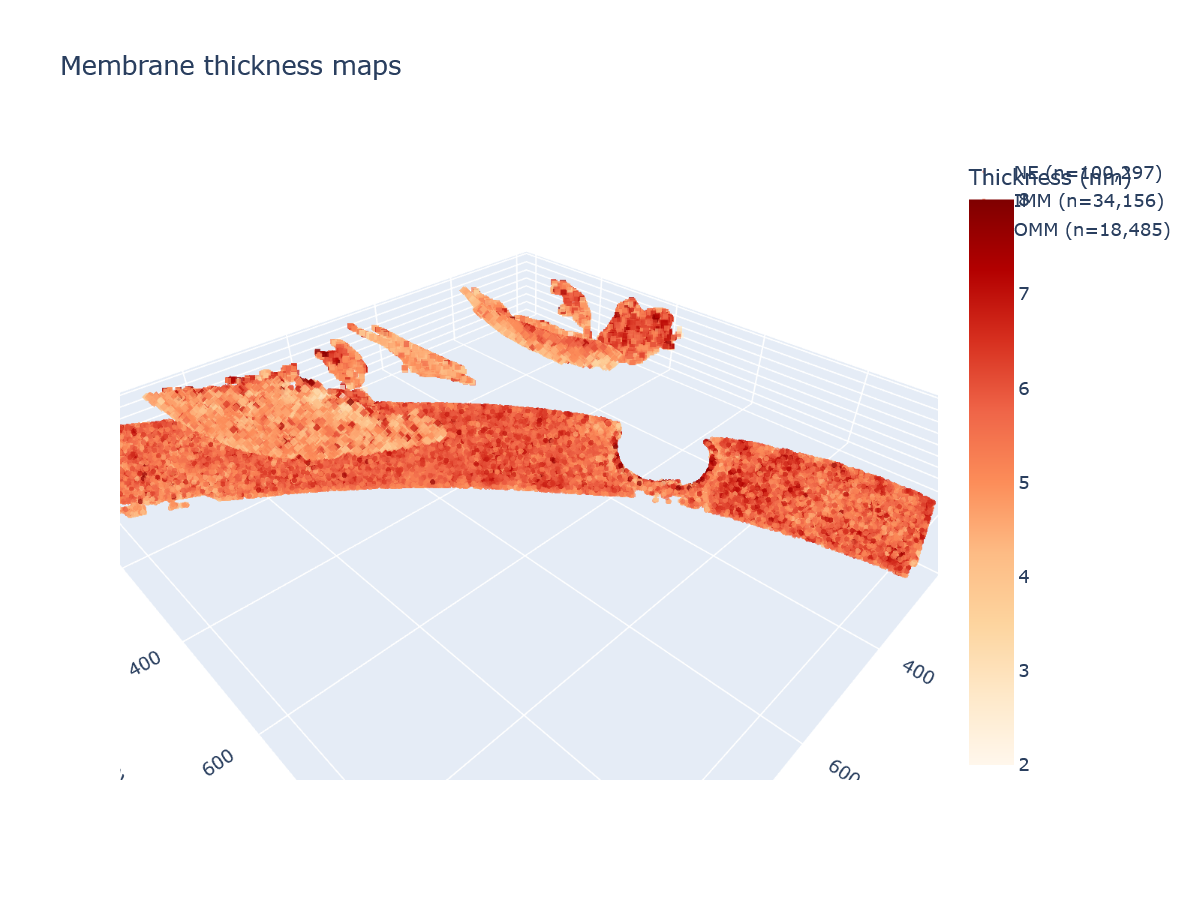

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/thickness_3d_plot.html)

In [ ]:
# Color membranes by their mean thickness
spatial_mean_plot = maple.plot_thickness_3d(
    [NE_thickness,IMM_thickness, OMM_thickness],
    membrane_names=['NE', 'IMM', 'OMM'],
    marker_size=2,
    plot_title='Mean membrane thickness map',
    color_by_mean=True,
    color_range = (4.5,6.5),
    color_scale = 'BuPu',
    sample_fraction=0.5  # Downsample for quicker visualization
)

#spatial_mean_plot.show()
spatial_mean_plot.write_html("plots/thickness_mean_plot.html", include_plotlyjs="cdn")

NE mean thickness: 5.72 nm
IMM mean thickness: 5.21 nm
OMM mean thickness: 4.85 nm


In [ ]:
IFrame("plots/thickness_mean_plot.html", width=800, height=600)

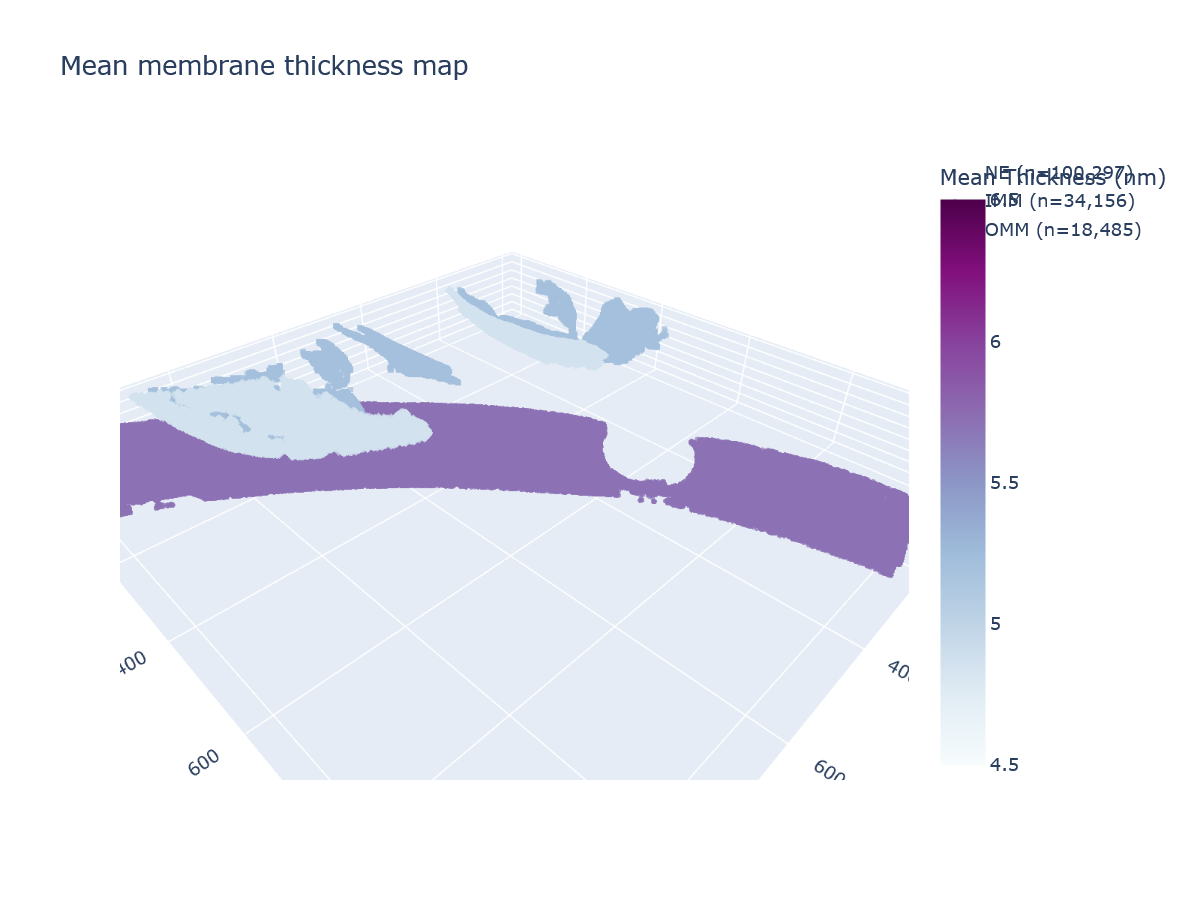

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/thickness_mean_plot.html)

### 3. Visualize surface assignment (PCA results)

In [ ]:
surface_plot = maple.plot_surfaces(
    data=NE_thickness,
    membrane_names=['NE'],
    surface1_color='#1f77b4',         # Blue for surface 1
    surface2_color='#ff7f0e',         # Orange for surface 2
    marker_size=3,
    sample_fraction=0.5,            # Downsample for quicker visualization
    plot_title='Assignment of surface points'
)

#surface_plot.show()
surface_plot.write_html("plots/surface_assignment_NE.html", include_plotlyjs="cdn")

NE: Surface 1 points: 100,297, Surface 2 points: 100,297


In [ ]:
IFrame("plots/surface_assignment_NE.html", width=800, height=600)

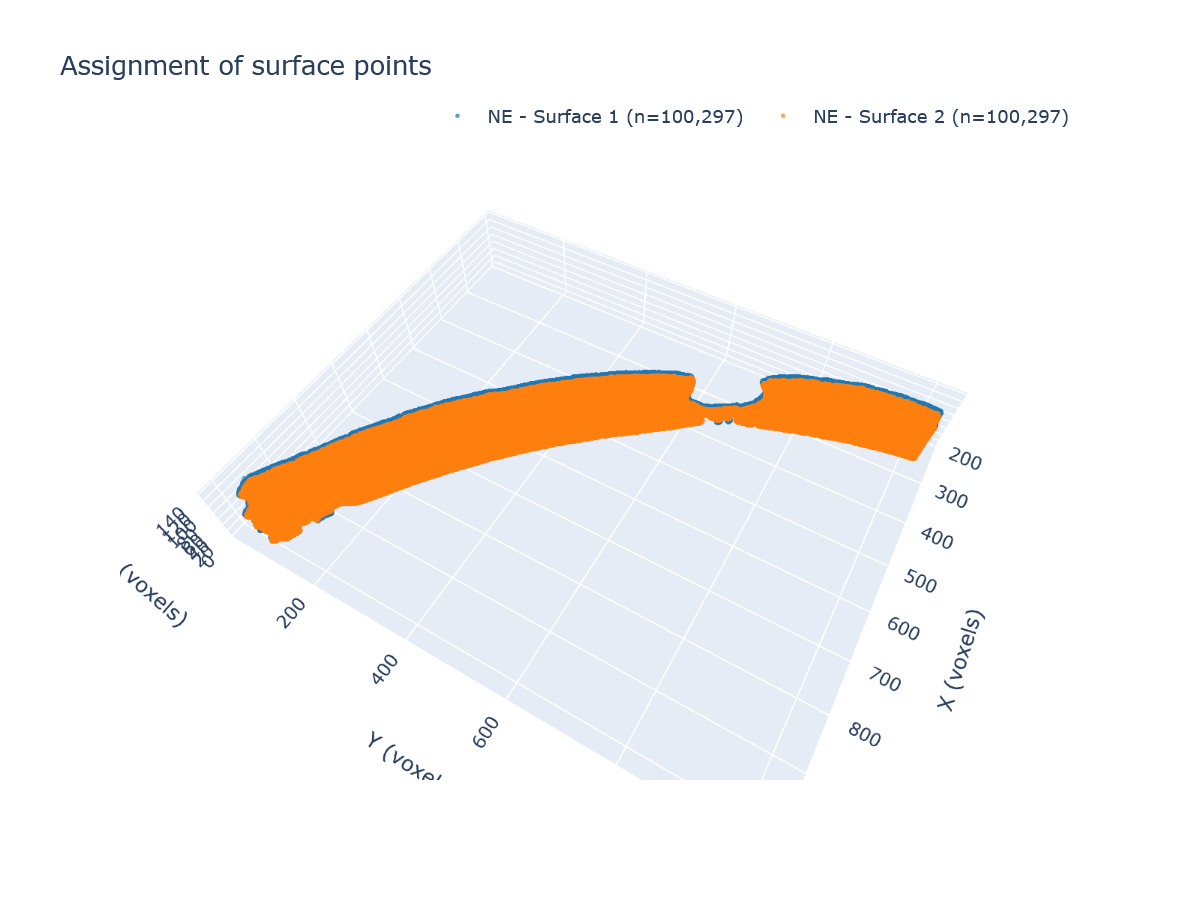

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/surface_assignment_NE.html)

### 4. Summarized intensity profiles (measurement points are projected as vertical lines)

In [ ]:
profile_plot = maple.plot_intensity_profile_summary(
    data=[NE_profiles_analysed, IMM_profiles_analysed, OMM_profiles_analysed], # Load results of analyze_intensity_profiles(), not directly the .pkl files
    membrane_names=['NE', 'IMM', 'OMM'],
    extension_range_voxels=(-8, 8),   # Generally keep the same as the parameter with which the pipeline was run, otherwise you'll get a straight line at intensity = 0
    voxel_size_nm=0.784,                # Convert x-axis to nm, otherwise will be shown in voxels
    show_individual_profiles=False,
    show_mean_profile=True,
    show_percentile_bands=True,
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
    plot_title='Extracted intensity profiles (summary)'
)

#profile_plot.show()
profile_plot.write_html("plots/intensity_profiles_all.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/intensity_profiles_all.html", width=800, height=600)

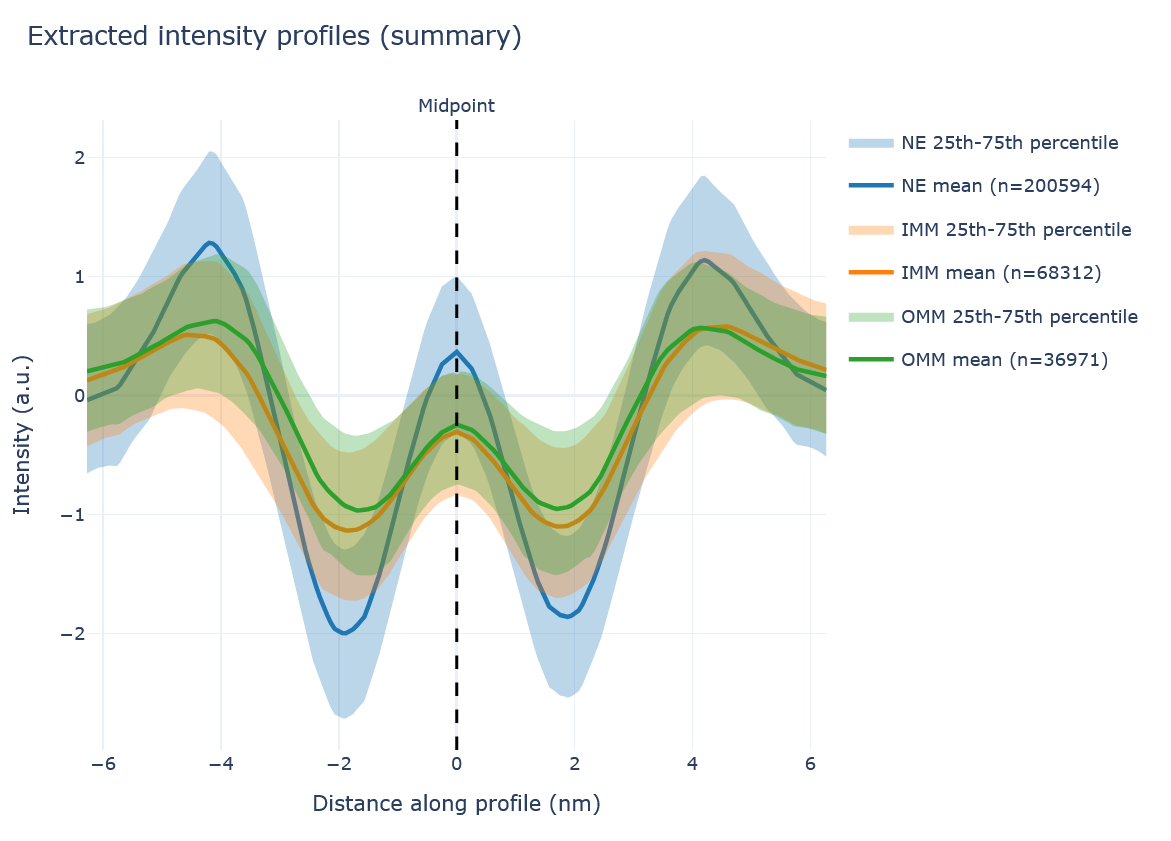

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/intensity_profiles_all.html)

### 5. Thickness-binned intensity profiles

In [ ]:
binned_plot = maple.plot_intensity_profile_binned(
    data=NE_profiles_analysed, # Load results of analyze_intensity_profiles(), not directly the .pkl files
    membrane_names=['NE'],
    thickness_bins=4,                  # Number of bins
    binning_method='quantile',         # Equal numbers of profiles per bin
    extension_range_voxels=(-8, 8),
    voxel_size_nm=0.784,
    plot_title='NE profiles per thickness quartile'
)

#binned_plot.show()
binned_plot.write_html("plots/intensity_profiles_NE_binned.html", include_plotlyjs="cdn")

Using 4 bins for NE:
  Bin 1: 1.9-5.3 nm: 56,777 profiles
  Bin 2: 5.3-5.7 nm: 59,631 profiles
  Bin 3: 5.7-6.1 nm: 59,829 profiles
  Bin 4: 6.1-8.0 nm: 54,622 profiles


In [ ]:
IFrame("plots/intensity_profiles_NE_binned.html", width=800, height=600)

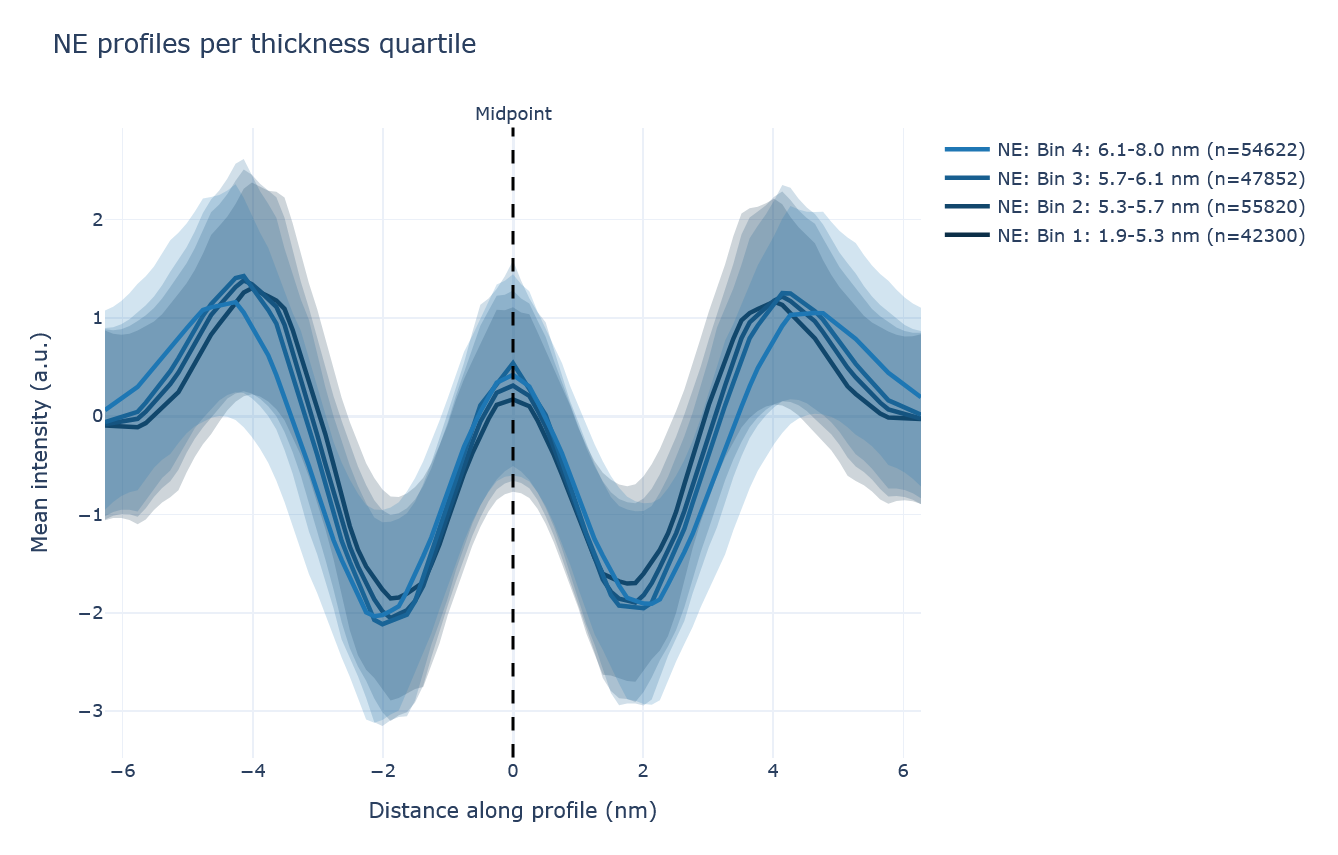

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/intensity_profiles_NE_binned.html)

In [ ]:
equal_width_plot = maple.plot_intensity_profile_binned(
    data=NE_profiles_analysed, # Load results of analyze_intensity_profiles(), not directly the .pkl files
    membrane_names=['NE'],
    thickness_bins=4,                  # Number of bins
    binning_method='equal_width',         # Divide the thickness range into bins with equal widths, different number of profiles per bin
    extension_range_voxels=(-8, 8),
    voxel_size_nm=0.784,
    plot_title='NE profiles binned by equal width'
)

#equal_width_plot.show()
equal_width_plot.write_html("plots/intensity_profiles_NE_binned_equal_width.html", include_plotlyjs="cdn")

Using 4 bins for NE:
  Bin 1: 1.9-3.4 nm: 41 profiles
  Bin 2: 3.4-5.0 nm: 19,851 profiles
  Bin 3: 5.0-6.5 nm: 160,298 profiles
  Bin 4: 6.5-8.0 nm: 20,404 profiles


In [ ]:
IFrame("plots/intensity_profiles_NE_binned_equal_width.html", width=800, height=600)

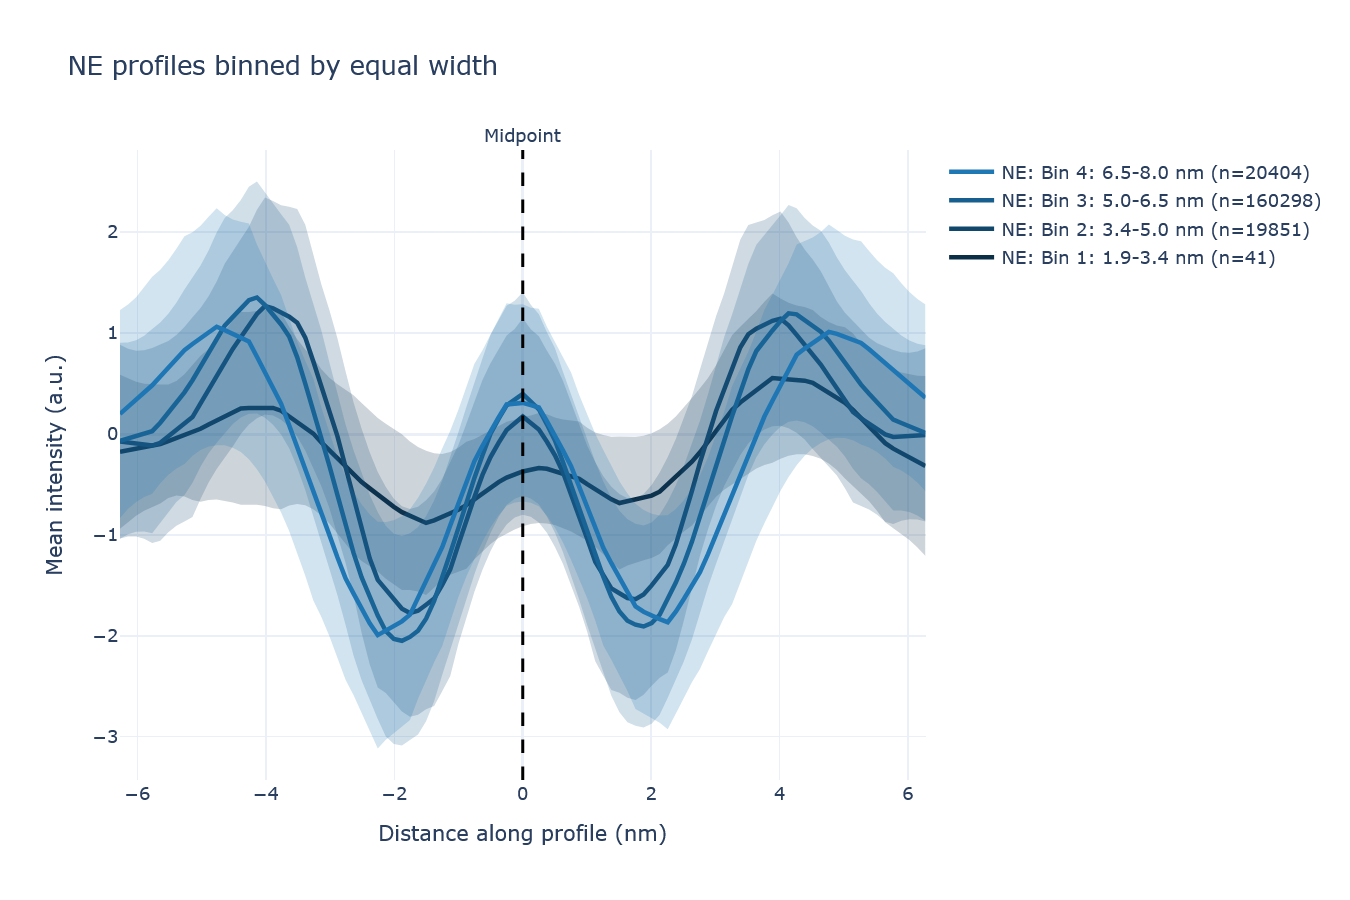

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/intensity_profiles_NE_binned_equal_width.html)

### 6. Visualize filtering results

In [ ]:
filtering_plot = maple.plot_excluded_included(
    thickness_csv=[NE_thickness_csv, IMM_thickness_csv, OMM_thickness_csv],
    membrane_names=['NE', 'IMM', 'OMM'],
    filtered_profiles_pkl=[NE_profiles, IMM_profiles, OMM_profiles],
    original_profiles_pkl=[NE_profiles_nonfiltered, IMM_profiles_nonfiltered, OMM_profiles_nonfiltered],
    plot_title='Excluded vs included point pairs'
    )

#filtering_plot.show()
filtering_plot.write_html("plots/excluded_vs_included_points.html", include_plotlyjs="cdn")

Loaded 221676 original and 200594 filtered profiles for NE
Profiles for NE - Passed: 200594, Failed: 21082
Loaded 112416 original and 68312 filtered profiles for IMM
Profiles for IMM - Passed: 68312, Failed: 44104
Loaded 70793 original and 36971 filtered profiles for OMM
Profiles for OMM - Passed: 36971, Failed: 33822


In [ ]:
IFrame("plots/excluded_vs_included_points.html", width=800, height=600)

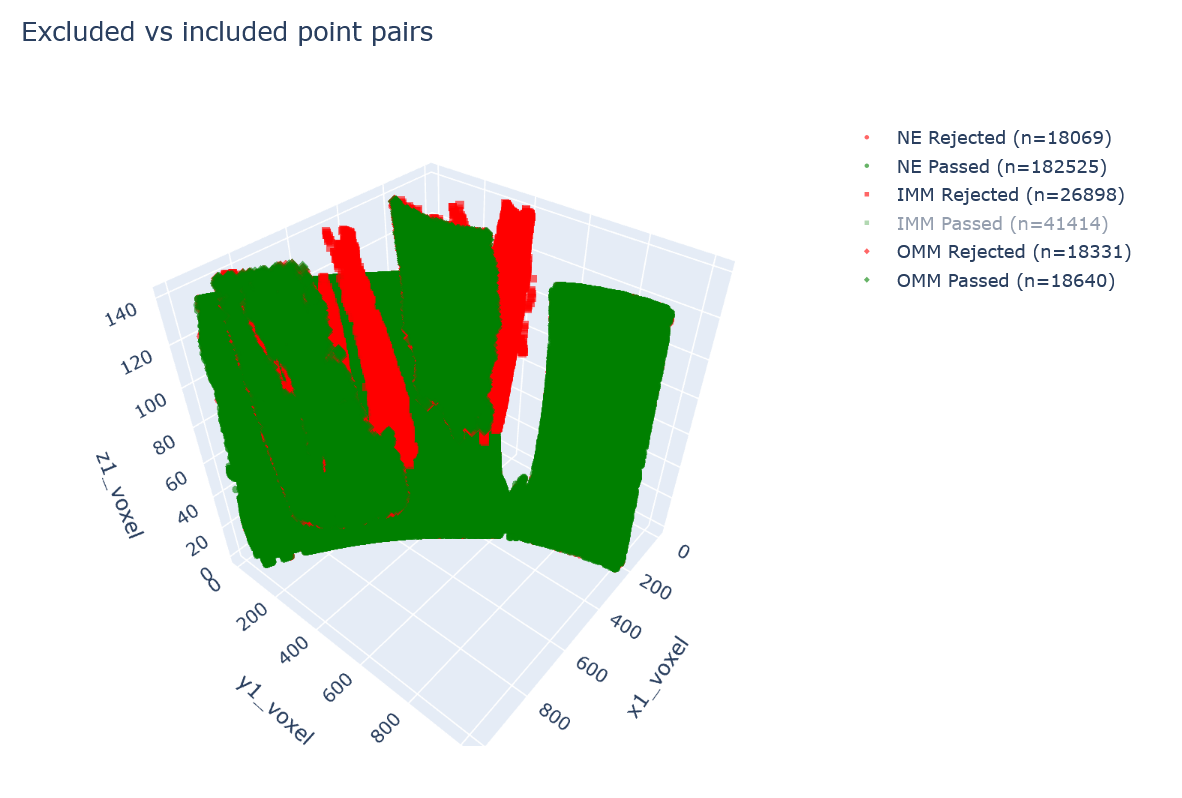

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/excluded_vs_included_points.html)

### 7. Leaflet asymmetry plots

In [ ]:
# Asymmetry histogram
asymmetry_hist = maple.plot_asymmetry_distribution(
    data=[NE_asymmetry, IMM_asymmetry, OMM_asymmetry],
    membrane_names=['NE', 'IMM', 'OMM'],
    use_percentages=True,              # Show as percentages
    histogram_bins=30,
    asymmetry_range=(0, 30),           # Percentage range
    y_axis_type='density',
    plot_title='Asymmetry distributions'
)

#asymmetry_hist.show()
asymmetry_hist.write_html("plots/asymmetry_hist.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/asymmetry_hist.html", width=800, height=600)

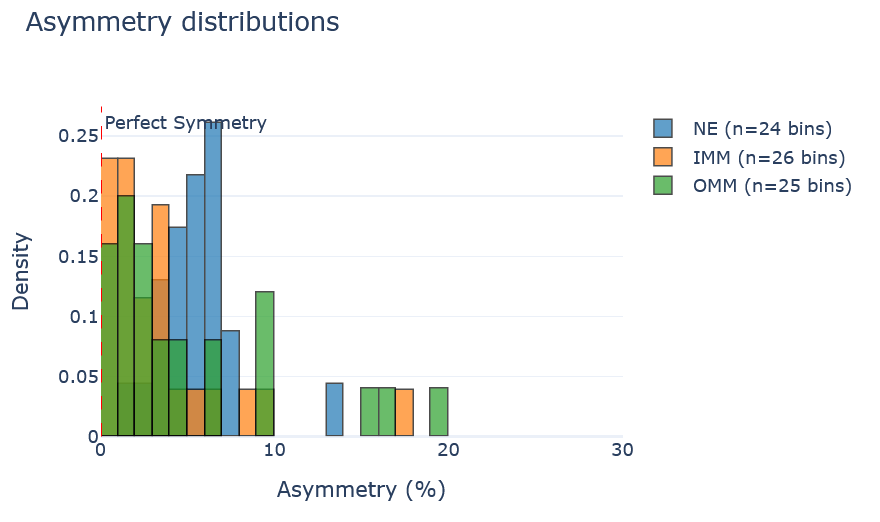

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/asymmetry_hist.html)

In [ ]:
# Asymmetry vs thickness relationship (to check for outliers)
bubble_plot = maple.plot_asymmetry_vs_thickness_bubble(
    data=[NE_asymmetry, IMM_asymmetry, OMM_asymmetry],
    membrane_names=['NE', 'IMM', 'OMM'],
    asymmetry_range=(0, 30),
    plot_title='Asymmetry vs thickness',
)

#bubble_plot.show()
bubble_plot.write_html("plots/asymmetry_bubble.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/asymmetry_bubble.html", width=800, height=600)

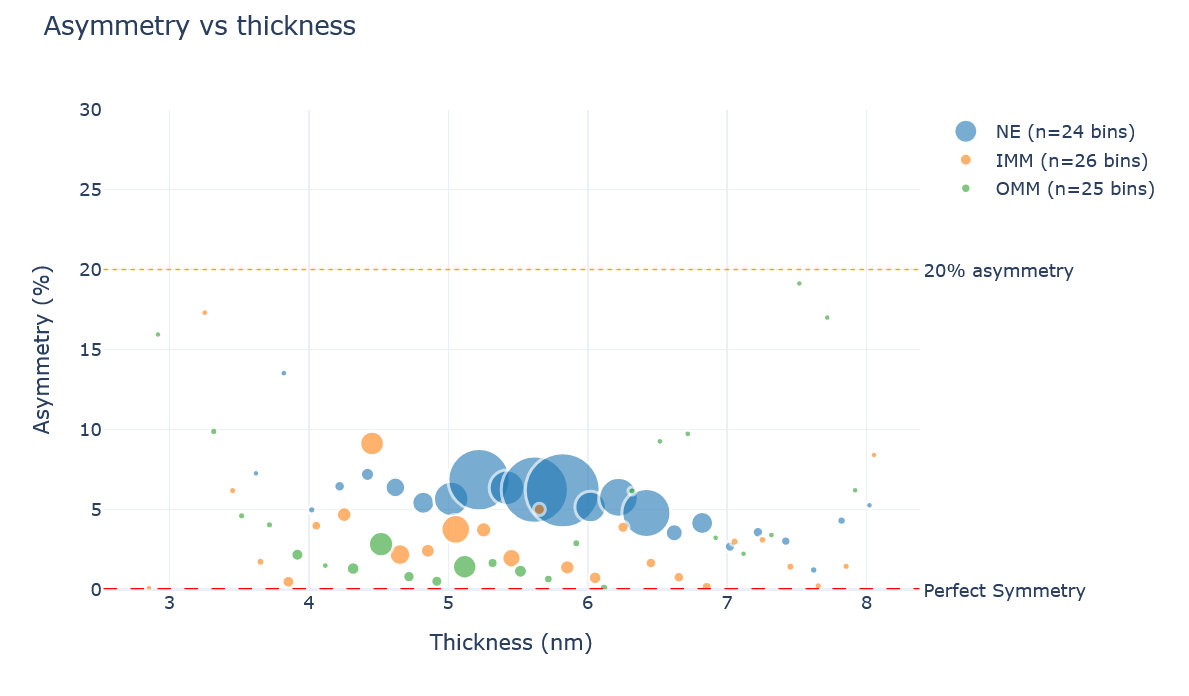

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/asymmetry_bubble.html)

In [ ]:
# Spatial asymmetry distribution
asymmetry_3d = maple.plot_asymmetry_3d(
    [NE_asymmetry, IMM_asymmetry, OMM_asymmetry],
    membrane_names=['NE', 'IMM', 'OMM'],
    asymmetry_range=(0,30),
    plot_title='Asymmetry 3D distribution',
    color_scale='BuPu',
    sample_fraction=0.5
)
#asymmetry_3d.show()
asymmetry_3d.write_html("plots/asymmetry_3d_plot.html", include_plotlyjs="cdn")

In [ ]:
IFrame("plots/asymmetry_3d_plot.html", width=800, height=600)

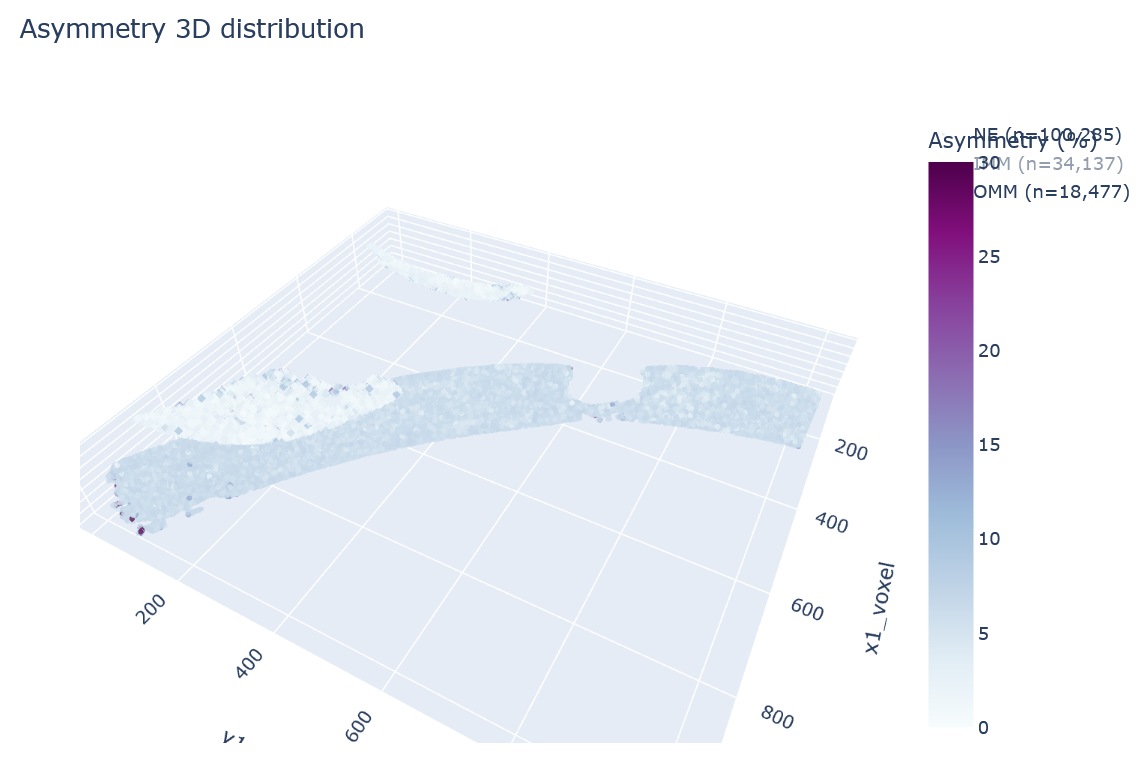

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/asymmetry_3d_plot.html)

### 8. Plot intensity minima-to-minima distances

The minima-to-minima distance is a feature of the profiles that is extracted during analysis and saved in the .pkl file as 'separation_distance'

In [ ]:
# Analyze separation between intensity minima
min_min_plot = maple.plot_min_to_min_distribution(
    data=[IMM_thickness, OMM_thickness],
    membrane_names=['IMM', 'OMM'],
    histogram_bins=40,
    separation_range=(1, 10),          # Distance range
    voxel_size_nm=0.784,              # Convert to nm, separation_distance is saved in voxels in the pipeline
    show_statistics=True,
    plot_title='Minima-to-minima distances'
)

#min_min_plot.show()
min_min_plot.write_html("plots/min_min_distances.html", include_plotlyjs="cdn")


Statistics for IMM:
  Mean: 3.92 nm
  Std:  1.05 nm
  Median: 3.82 nm
  Range: 1.45 - 9.65 nm
  Count: 68,304

Statistics for OMM:
  Mean: 3.76 nm
  Std:  0.98 nm
  Median: 3.66 nm
  Range: 1.45 - 9.53 nm
  Count: 36,970


In [ ]:
IFrame("plots/min_min_distances.html", width=800, height=600)

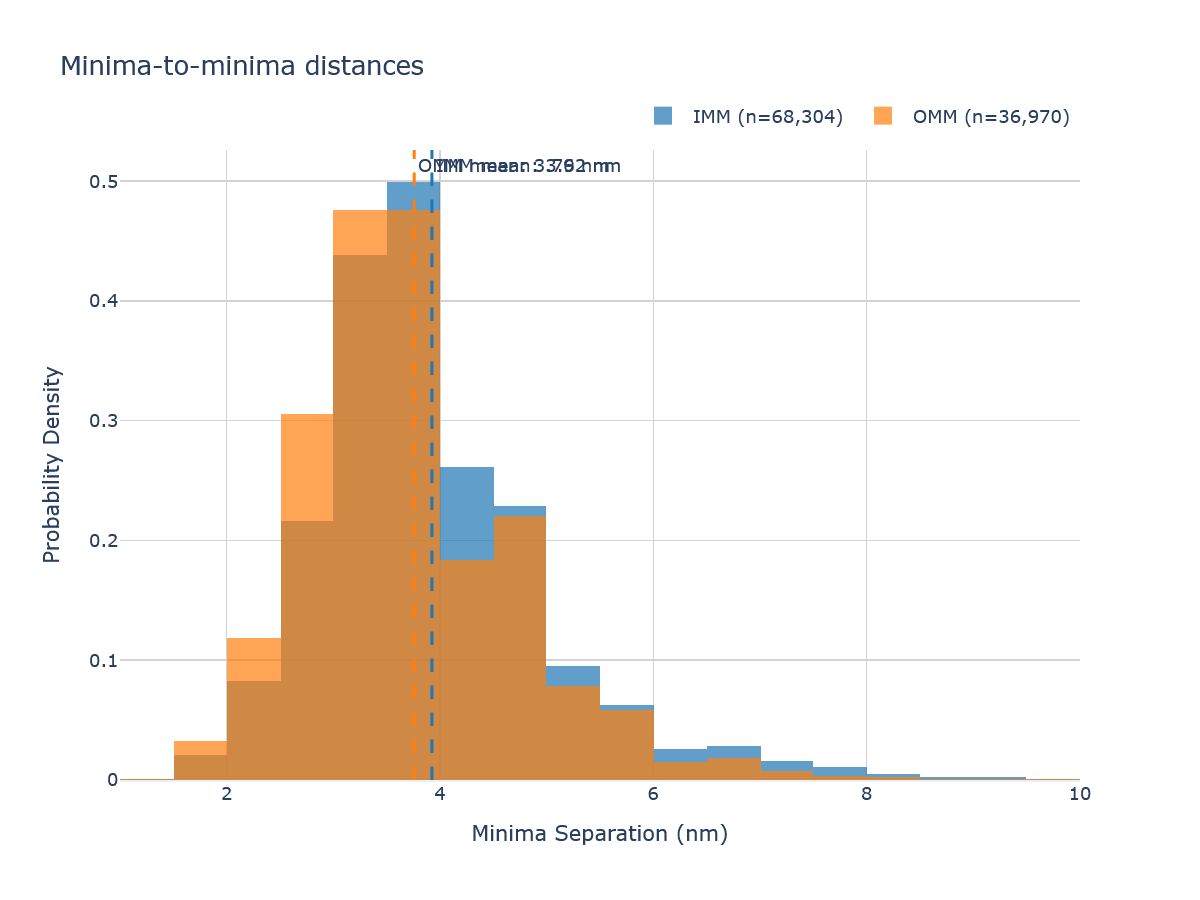

&nbsp;&nbsp;&nbsp;&nbsp; [Download interactive version](../../_static/plots/min_min_distances.html)

## Extract Coordinates of Matched Measurement Points

In [23]:
# Extract the coordinates of matched points - can be used to check with the original tomogram
# Returns a dataframe

coord_table = maple.create_profile_coordinates_table(
    membrane_data=NE_data,
    spatial_bounds={                  # Optional, if not specified, will extract all measurement point coordinates
        'x': (900, 1000),             # X range in voxels
        'y': (50, 150),               # Y range in voxels  
        'z': (10, 20)                 # Z range in voxels
    },
    include_thickness_data=True,
    include_profile_metadata=True,
)
print(f"Found {len(coord_table)} profiles in region")
coord_table.head()

Found 1558 profiles in region


,profile_index,p1_x,p1_y,p1_z,p2_x,p2_y,p2_z,thickness_nm,passes_filter,has_features,profile_length,minima_between_points,separation_distance,prominence_snr
0,9727,976,54,10,979,60,8,5.488000,True,True,24,True,4.173913,3.553441
1,9730,971,56,10,975,62,7,6.123236,True,True,25,True,4.666667,8.587264
2,9733,972,56,10,974,62,7,5.488000,True,True,24,True,5.565217,4.650548
3,9736,973,56,10,974,62,8,5.020050,True,True,24,True,4.869565,3.060674
4,9738,966,59,10,969,65,7,5.761200,True,True,25,True,5.333333,7.102457


## Convert Thickness Data Into Motive Lists
Can be useful for ChimeraX visualization

In [24]:
maple.save_thickness_motls(NE_thickness_csv, output_directory='outputs/')
maple.save_thickness_motls(IMM_thickness_csv, output_directory='outputs/')
maple.save_thickness_motls(OMM_thickness_csv, output_directory='outputs/')

Saved motls with 200594 points
Saved motls with 68312 points
Saved motls with 36971 points
